# Project 3 Source Code

## Imports

In [1]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision.transforms.functional import resize
from torch.nn.functional import conv2d, pad
import torch
from project2_cuda import corner_nms, ncc, harris_corner
from typing import Tuple, Union
from glob import glob
from os.path import join
import matplotlib
import random
import tqdm
import cv2
matplotlib.rcParams['figure.figsize'] = [10, 10]

## Convenience Methods

In [2]:
def read_image(path: str) -> torch.Tensor:
    return torch.tensor(np.array(Image.open(path))).type(torch.float32)

def read_images(paths):
    return [read_image(path) for path in paths]

def get_patch_rads(x, y, patch_rad, r, c):
    patch_x_begin = x if x - patch_rad < 0 else patch_rad
    patch_x_end = r - x if x + patch_rad > r else patch_rad
    patch_y_begin = y if y - patch_rad < 0 else patch_rad
    patch_y_end = r - y if y + patch_rad > c else patch_rad
    return patch_x_begin, patch_x_end, patch_y_begin, patch_y_end


def rgb2gray(img: torch.Tensor) -> torch.Tensor:
    """
    Converts an RGB image to Grayscale
    :param img: the RGB image as a pytorch tensor
    :return: The image as grayscale
    """
    return torch.mean(img, dim=2)


def downscale(img: torch.Tensor, factor):
    """
    downscales the size of the given image by the given factor
    :param img: the image as a pytorch Tensor
    :param factor: the factor by which the dimensions of the input
    image will be downsampled by
    :return: the downscaled image as a pytorch Tensor
    """
    r, c = img.size()
    r = r // factor
    c = c // factor
    return resize(img.unsqueeze(0), [r, c]).squeeze()
        
        

def convolve2d(img: Union[np.ndarray, torch.Tensor], weight: Union[np.ndarray, torch.Tensor],
             padding: str = 'same') -> torch.Tensor:
    """
    A convenience function for convolving 2D images with 2D filters using Pytorch 2D convolution.
    Does not alter the device of the tensor, but converts the data type to torch.float32.
    :param img:
    :param weight:
    :param padding:
    :return:
    """
    if isinstance(img, np.ndarray):
        img = torch.from_numpy(img).float()
    if isinstance(weight, np.ndarray):
        weight = torch.from_numpy(weight).float()

    assert len(img.shape) == 2 and len(weight.shape) == 2
    assert img.device == weight.device

    img = img.unsqueeze(0).unsqueeze(0)
    weight = weight.unsqueeze(0).unsqueeze(0)
    return conv2d(img, weight, padding=padding).squeeze()

## Noise Removal functions

In [3]:
# Box filter for smoothing
def box_filter(img: Union[np.ndarray, torch.Tensor], diameter: int, padding: str = 'same') -> torch.Tensor:
    """
    Applies box filter to the given image
    :param padding: Padding to be used for filtering
    :param img: Image of interest as a torch.Tensor
    :param diameter: the diameter of the box filter
    :return: filtered image.
    """
    box = torch.ones([diameter, diameter],
                     dtype=torch.float,
                     device=img.device) / diameter**2
    return convolve2d(img, box, padding)

def gaussian_filter(img: Union[np.ndarray, torch.Tensor], s_sigma: float, padding: str = 'same') -> torch.Tensor:
    filt_rad = int(np.floor(5 * s_sigma))
    offset = filt_rad // 2
    g_filt_2d = torch.zeros((filt_rad, filt_rad), dtype=torch.float32, device=img.device)
    for i in range(filt_rad):
        for j in range(filt_rad):
            g_filt_2d[i, j] = np.exp(-((i - offset)**2 + (j - offset)**2) / (2 * s_sigma**2))
    g_filt_2d = g_filt_2d / g_filt_2d.sum()
    return convolve2d(img, g_filt_2d, padding)

## Gradient Estimation Functions

In [4]:
def sobel_x(img: torch.Tensor, padding: str = 'same') -> torch.Tensor:
    """
    Computes the gradient of the image in the x-direction using
    a sobel filter.
    :param padding: padding type to use when applying the filter. Follows the convention of Pytorch padding types
    :param img: image of interest, as a torch.Tensor. Can be
    on both GPU and CPU
    :return: Gradient estimate of the image, as a torch.Tensor,
    on the same device as the img
    """
    sobel_x_filter = torch.tensor([[1., 0., -1.],
                                   [2., 0., -2.],
                                   [1., 0., -1.]], device=img.device)
    return convolve2d(img, sobel_x_filter, padding)


def sobel_y(img: torch.Tensor, padding: str = 'same'):
    """
    Computes the gradient of the image in the y-direction using
    a sobel filter.
    :param img: image of interest, as a torch.Tensor. Can be
    on both GPU and CPU
    :return: Gradient estimate of the image, as a torch.Tensor,
    on the same device as the img
    """
    sobel_y_filter = torch.tensor([[1., 2., 1.],
                                   [0., 0., 0.],
                                   [-1., -2., -1.]
                                   ], device=img.device)
    return convolve2d(img, sobel_y_filter, padding)


def estimate_gradient_dirs(img: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    return sobel_x(img), sobel_y(img)

## Harris Corner Detector Functions

In [5]:
def harris_corner_detector(image, radius, threshold=0.02, k=0.05, sigma=1):
    image = gaussian_filter(image, sigma)
    # Find gradients
    Ix, Iy = estimate_gradient_dirs(image)
    # Apply harris corner detection
    R = harris_corner(Ix, Iy, radius, k)
    
    # Threshold values
    R[R < threshold * torch.max(R)] = 0
    
    # Nonmax Supression
    R = corner_nms(R, radius)

    return R


# Reduce threshold until ~1% of pixels are corners
def reduced_harris(image, radius, k, sigma, target_corner_ratio):
    threshold = 1.
    corner_image_ratio = 0.
    corners = None
    while corner_image_ratio < target_corner_ratio:
        corners = harris_corner_detector(image, radius, threshold, k, sigma)
        corner_image_ratio = (corners > 0).sum() / image.numel()
        threshold = 0.9 * threshold
    return corners

### Visualization Functions

In [6]:
def vis_dist_map_single_axis(img, dist_map):
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
    if isinstance(dist_map, torch.Tensor):
        dist_map = dist_map.cpu().numpy()
    plt.imshow(img, cmap='gray')
    max_dim = max(*img.shape)
    dist_im_plt = plt.imshow(dist_map, cmap='jet', alpha=0.5)
    plt.colorbar(dist_im_plt)
    plt.show()

## Image Loading and Pre-processing

In [7]:
cones_files = ['Cones_im2.jpg', 'Cones_im6.jpg']
cast_files = ['cast-left-1.jpg', 'cast-right.jpg']

cones_images = read_images(cones_files)
cast_images = read_images(cast_files)
cones_images = [downscale(rgb2gray(img).cuda(), 1) for img in cones_images]
cast_images = [downscale(rgb2gray(img).cuda(), 1) for img in cast_images]

## Harris Corner Detection Stage for Hallway Dataset

Applying Harris Corner Detection to Cast
Number of corners found: 471


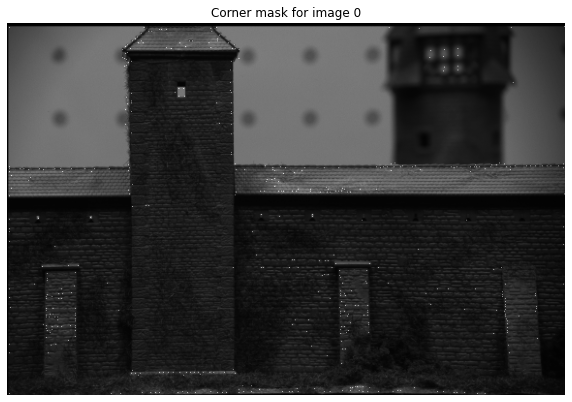

Number of corners found: 482


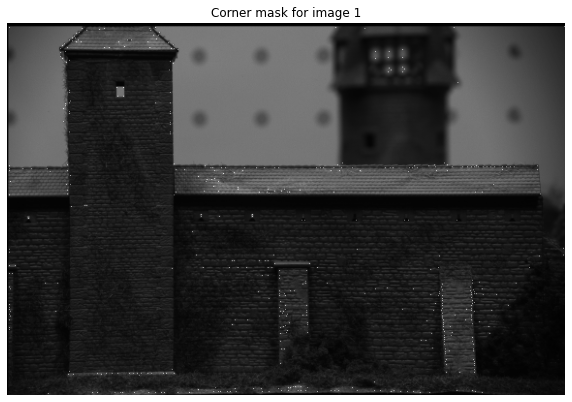

In [8]:
radius = 1
k = 0.04
sigma = 1
target_ratio = 0.002

print("Applying Harris Corner Detection to Cast")
cast_corner_masks = []
for i, img in enumerate(cast_images):
    corner_mask = reduced_harris(img, radius, k, sigma, target_ratio)
    print(f"Number of corners found: {(corner_mask > 0).sum()}")
    fig, ax = plt.subplots()
    ax.imshow(img.cpu().numpy(), cmap='gray')
    ax.imshow(corner_mask.cpu().numpy() > 0, cmap='gray', alpha=0.5)
    ax.set_title(f'Corner mask for image {i}')
    plt.axis('off')
    plt.show()
    cast_corner_masks.append(corner_mask)

### Harris Corner Detection Stage for Cones

Applying Harris Corner Detection to Cones
Number of corners found: 346


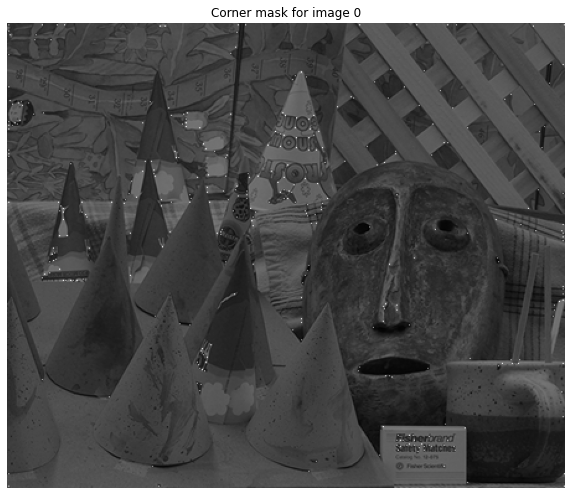

Number of corners found: 361


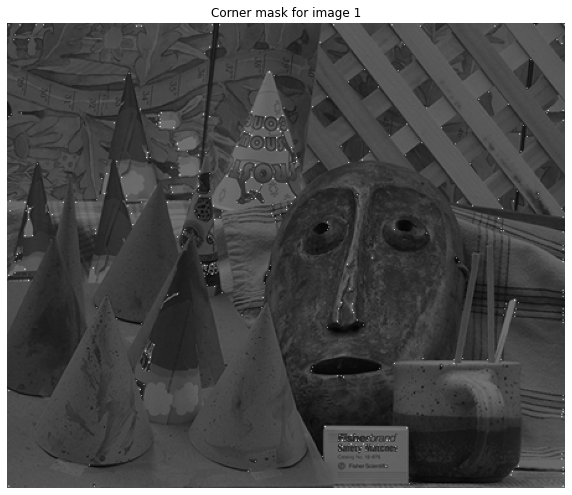

In [9]:
radius = 1
k = 0.04
sigma = 1
target_ratio = 0.002

print("Applying Harris Corner Detection to Cones")
cones_corner_masks = []
for i, img in enumerate(cones_images):
    corner_mask = reduced_harris(img, radius, k, sigma, target_ratio)
    print(f"Number of corners found: {(corner_mask > 0).sum()}")
    fig, ax = plt.subplots()
    ax.imshow(img.cpu().numpy(), cmap='gray')
    ax.imshow(corner_mask.cpu().numpy() > 0, cmap='gray', alpha=0.5)
    ax.set_title(f'Corner mask for image {i}')
    plt.axis('off')
    plt.show()
    cones_corner_masks.append(corner_mask)

### Feature Matching Function

In [10]:
# Normalized Cross Correlation of two equal shaped patches
def patch_ncc(f, g):
    len_f = torch.sqrt(torch.sum(f**2))
    len_g = torch.sqrt(torch.sum(g**2))
    return (f * g).sum() / (len_f * len_g)

# Find matches from im1 to im2
def patch2patch(im1, im2, corner_mask_1, corner_mask_2, radius):
    
    num_corners_1 = (corner_mask_1 > 0).sum()
    num_corners_2 = (corner_mask_2 > 0).sum()
    num_matches = min(num_corners_1, num_corners_2)
    
    # Patch from location
    def get_patch(im, x, y, radius):
        return im[x - radius: x + radius + 1,
               y - radius: y + radius + 1]

    def corner_coord(corner_mask):
        corner_coords = torch.where(corner_mask > 0)
        corner_coords = torch.stack(corner_coords).T.cpu()
        return corner_coords

    # Find patch coordinates
    corner_coords_1 = corner_coord(corner_mask_1)
    corner_coords_2 = corner_coord(corner_mask_2)

    matches = torch.zeros([num_matches, 5], dtype=torch.float32)
    
    for i in range(num_matches):
        x_1 = corner_coords_1[i, 0]
        y_1 = corner_coords_1[i, 1]
  
        # Match the patch to second image
        patch1 = get_patch(im1, x_1, y_1, radius)
        best_match = torch.tensor([x_1, y_1, 0, 0, 0.])
        for j in range(corner_coords_2.shape[0]):
            x_2 = corner_coords_2[j, 0]
            y_2 = corner_coords_2[j, 1]
            patch2 = get_patch(im2, x_2, y_2, radius)
            if patch2.shape == patch1.shape and patch1.numel() != 0:
                ncc = patch_ncc(patch1, patch2)
                if ncc >= best_match[4]:
                    best_match = torch.tensor([x_1, y_1, x_2, y_2, ncc],
                                              dtype=torch.float32)

        matches[i] = best_match

    return matches

def prune_matches(matches, threshold):
    pruned_matches = []
    for match in matches:
        if match[-1] >= threshold:
            pruned_matches.append(match)
    return torch.stack(pruned_matches) if pruned_matches else torch.empty(0)


def drawLines(image1, image2, matches):
    """
    Draw lines between matches
    """

    offset = image1.shape[0]
    x = np.copy(matches[:,0:4:2])
    x[:,1] = x[:,1] + offset
    y = np.copy(matches[:,1:4:2])

    both = np.vstack([image1,image2])
    plt.imshow(both,cmap='gray')
    for i in range(0, x.shape[0]):
        plt.plot(y[i,:], x[i,:])
    plt.axis('off')
    plt.show()
    return

### Feature Matching for Cast

Finding matches for Cast
471 matches found.
202 were selected.


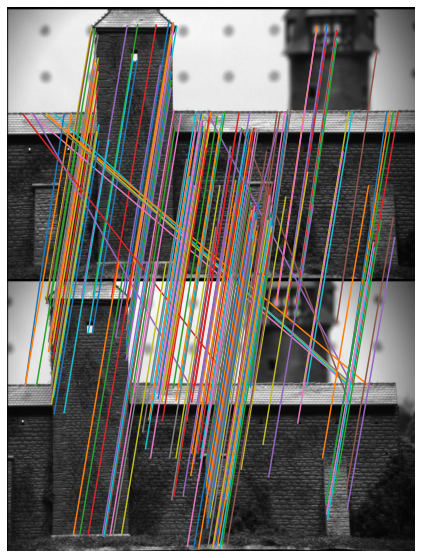

In [11]:
# Find matches
print('Finding matches for Cast')
radius = 20
threshold = 0.99
cast_matches = []
for i in range(len(cast_images) - 1):
    im1, corner_mask_1 = cast_images[i], cast_corner_masks[i]
    im2, corner_mask_2 = cast_images[i + 1], cast_corner_masks[i + 1]
    matches = patch2patch(im1, im2, corner_mask_1, corner_mask_2, radius)
    print(f"{len(matches)} matches found.")
    pruned_matches = prune_matches(matches, threshold)
    print(f"{len(pruned_matches)} were selected.")
    if len(pruned_matches) != 0:
        drawLines(im1.cpu().numpy(), im2.cpu().numpy(), pruned_matches)
    cast_matches.append(pruned_matches)

### Feature Matching for Cone

Finding matches for Cone
346 matches found.
96 were selected.


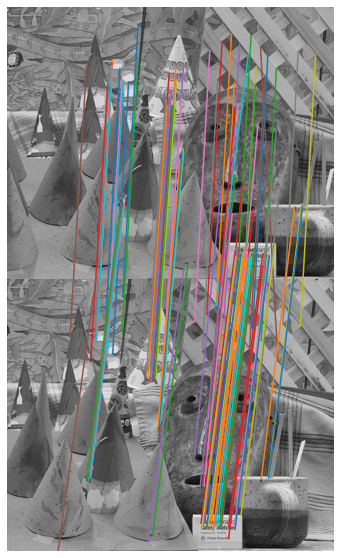

In [12]:
# Find matches
print('Finding matches for Cone')
radius = 20
threshold = 0.99
cone_matches = []
for i in range(len(cones_images) - 1):
    im1, corner_mask_1 = cones_images[i], cones_corner_masks[i]
    im2, corner_mask_2 = cones_images[i + 1], cones_corner_masks[i + 1]
    matches = patch2patch(im1, im2, corner_mask_1, corner_mask_2, radius)
    print(f"{len(matches)} matches found.")
    pruned_matches = prune_matches(matches, threshold)
    print(f"{len(pruned_matches)} were selected.")
    if len(pruned_matches) != 0:
        drawLines(im1.cpu().numpy(), im2.cpu().numpy(), pruned_matches)
    cone_matches.append(pruned_matches)

### Fundamental Calculation Function + RANSAC

In [13]:
def calculate_fundamental_matrix(matches, device):
    A = []
    for match in matches:
        if isinstance(match, np.ndarray):
            match = torch.from_numpy(match)
        x = match[1].item()
        y = match[0].item()
        x_p = match[3].item()
        y_p = match[2].item()
        A.append([x * x_p, x * y_p, x, y * x_p, y * y_p, y, x_p, y_p, 1])

    A = torch.tensor(A).to(device)
    u, s, v = torch.linalg.svd(A)
    # Extract the minimum eigenvalue and normalize
    h = v[8].reshape(3, 3)
    # Enforce singularity constraint
    U, S, V = h.svd()
    S[-1] = 0
    h = U.mm(S * torch.eye(len(S))).mm(V.T)
    # Enforce unit norm constraint
    h = h / h.norm()
    return h

def line_check(match, f):
    p_1 = torch.tensor([[match[1], match[0], 1]]).T
    p_2 = torch.tensor([[match[3], match[2], 1]])
    return torch.abs(p_2.mm(f).mm(p_1)).item()


def ransac(matches, num_trials, thres=5, device='cpu'):
    max_inliers = []
    best_f = torch.empty(0)
    iterator = tqdm.tqdm(range(num_trials))
    for i in iterator:
        rng = np.random.default_rng()
        eight_random_idx = rng.choice(len(matches), 8, replace=False)
        eight_random_pts = torch.vstack([matches[idx] for idx in eight_random_idx])
        f = calculate_fundamental_matrix(eight_random_pts, device)
        curr_inliers = []
        for match in matches:
            if line_check(match, f) < thres:
                curr_inliers.append(match)
        
        if len(curr_inliers) > len(max_inliers):
            max_inliers = curr_inliers
            best_f = f
        iterator.set_postfix_str(f"Max inliers: {len(max_inliers)}, Current inliers: {len(curr_inliers)}")
    return best_f, torch.vstack(max_inliers)


### Fundamental Matrix Calculation for Cast

In [14]:
f_matrix_cast = []
num_trials = 5000
thres = 0.001
for match in cast_matches:
    _, inliers = ransac(match, num_trials, thres=thres)
    f = calculate_fundamental_matrix(inliers, 'cpu') if len(inliers) != 0 else None
    f_matrix_cast.append(f)
print(f_matrix_cast)

100%|██████████| 5000/5000 [00:47<00:00, 105.01it/s, Max inliers: 147, Current inliers: 0]  


[tensor([[-1.3555e-14, -1.9045e-07,  1.5252e-07],
        [ 1.4110e-09,  5.9605e-08,  7.0711e-01],
        [-5.1457e-08, -7.0711e-01, -6.2585e-07]])]


### Fundamental Matrix Calculation for Cone

In [15]:
f_matrix_cones = []
num_trials = 5000
thres = 0.001
for match in cone_matches:
    _, inliers = ransac(match, num_trials, thres=thres)
    f = calculate_fundamental_matrix(inliers, 'cpu')
    f_matrix_cones.append(f)
print(f_matrix_cones)

100%|██████████| 5000/5000 [00:26<00:00, 189.84it/s, Max inliers: 93, Current inliers: 0] 


[tensor([[ 3.3658e-16, -8.0310e-09, -1.0508e-07],
        [-2.6115e-09, -2.9802e-08,  7.0711e-01],
        [-4.5340e-09, -7.0711e-01, -7.4506e-09]])]


### Constrained Dense Disparity Map Search

### Disparity Map Calculation

In [17]:
def disparity_map(left_img, right_img, radius, f, dis_range):
    r,c = left_img.shape
    disp_map = torch.zeros([r, c, 2])
    match_map = torch.zeros([r, c, 2])
    accuracy_map = torch.zeros_like(left_img)
    iterator = tqdm.tqdm(range(radius, r - radius))
    for i in iterator:
        for j in range(radius, c - radius):
            left_range = dis_range[0] if i - dis_range[0] >= radius else 0
            right_range = dis_range[1] if i + dis_range[1] < r - radius else 0
            left_patch = left_img[i - radius:i + radius,
                                    j - radius:j + radius]

            best = 0
            p_1 = torch.tensor([[i, j, 1]]).float().T
            line_eq = f.mm(p_1)
            for x in range(i - left_range,
                           i + right_range):
                y = int(- ((line_eq[0] * x + line_eq[2]) / line_eq[1]).item())
                if radius <= y < c - radius:
                    right_patch = right_img[x - radius:x + radius,
                                           y - radius:y + radius]
                    new = patch_ncc(left_patch, right_patch)

                    if new > best:
                        disp_map[i, j, 0] = np.abs(x - i)
                        disp_map[i, j, 1] = np.abs(y - j)
                        match_map[i, j, 0] = x
                        match_map[i, j, 1] = y
                        accuracy_map[i, j] = new
                        best = new
    return disp_map, match_map, accuracy_map

### Disparity Map Calculation for Cast

In [ ]:
cast_disp_map, cast_match_map, cast_accuracy_map = disparity_map(cast_images[0].cpu(),
                                                                 cast_images[1].cpu(),
                                                                 5,
                                                                 f_matrix_cast[0],
                                                                 (100, 0))

### Disparity Map Calculation for Cones

In [ ]:
cone_disp_map, cone_match_map, cone_accuracy_map = disparity_map(cones_images[0].cpu(),
                                                                 cones_images[1].cpu(),
                                                                 5,
                                                                 f_matrix_cones[0],
                                                                 (100, 0))

In [ ]:
## Sample code from the internet
import numpy as np

def sum_of_abs_diff(pixel_vals_1, pixel_vals_2):
    """
    Args:
        pixel_vals_1 (numpy.ndarray): pixel block from left image
        pixel_vals_2 (numpy.ndarray): pixel block from right image

    Returns:
        float: Sum of absolute difference between individual pixels
    """
    if pixel_vals_1.shape != pixel_vals_2.shape:
        return -1
    # return - patch_ncc(torch.from_numpy(pixel_vals_1), torch.from_numpy(pixel_vals_2))
    return np.sum(np.abs(pixel_vals_1 - pixel_vals_2))

BLOCK_SIZE = 15
SEARCH_BLOCK_SIZE = 100

def compare_blocks(y, x, block_left, right_array, block_size=5):
    """
    Compare left block of pixels with multiple blocks from the right
    image using SEARCH_BLOCK_SIZE to constrain the search in the right
    image.

    Args:
        y (int): row index of the left block
        x (int): column index of the left block
        block_left (numpy.ndarray): containing pixel values within the
                    block selected from the left image
        right_array (numpy.ndarray]): containing pixel values for the
                     entrire right image
        block_size (int, optional): Block of pixels width and height.
                                    Defaults to 5.

    Returns:
        tuple: (y, x) row and column index of the best matching block
                in the right image
    """
    # Get search range for the right image
    x_min = max(0, x - SEARCH_BLOCK_SIZE)
    x_max = min(right_array.shape[1], x + SEARCH_BLOCK_SIZE)
    #print(f'search bounding box: ({y, x_min}, ({y, x_max}))')
    first = True
    min_sad = None
    min_index = None
    for x in range(x_min, x_max):
        block_right = right_array[y: y+block_size,
                                  x: x+block_size]
        sad = sum_of_abs_diff(block_left, block_right)
        #print(f'sad: {sad}, {y, x}')
        if first:
            min_sad = sad
            min_index = (y, x)
            first = False
        else:
            if sad < min_sad:
                min_sad = sad
                min_index = (y, x)

    return min_index


h, w = cast_images[0].shape
disparity_map = np.zeros((h, w))
left_array = cast_images[0].cpu().numpy()
right_array = cast_images[1].cpu().numpy()
for y in tqdm.tqdm(range(BLOCK_SIZE, h-BLOCK_SIZE)):
        for x in range(BLOCK_SIZE, w-BLOCK_SIZE):
            block_left = left_array[y:y + BLOCK_SIZE,
                                    x:x + BLOCK_SIZE]
            min_index = compare_blocks(y, x, block_left,
                                       right_array,
                                       block_size=BLOCK_SIZE)
            disparity_map[y, x] = abs(min_index[1] - x)

def calculate_disparity_v2(left_img, right_img, d, max_dis_range):
    h, w = left_img.shape
    disparity_map = torch.zeros_like(left_img)

In [ ]:
plt.imshow(disparity_map, cmap='jet')
plt.show()
